# Training the same model without pretrained word embeddings

# Processing the labels of the raw IMDB data

In [1]:
import os
train_dir = 'E:/aclImdb/aclImdb/train'
labels = []
texts = []

In [2]:
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname),encoding ='utf-8' )
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [3]:
len(texts)

25000

In [4]:
len(labels)

25000

# Tokenizing the text of the raw IMDB data

In [5]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

In [6]:
maxlen = 100
training_samples = 4200
validation_samples = 10000
max_words = 10000

In [7]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [8]:
data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [9]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# Parsing the GloVe word-embeddings file

In [10]:
glove_dir = 'E:/glove.6B'

embeddings_index = {}

f = open(os.path.join(glove_dir, 'glove.6B.100d.txt'),encoding = 'utf-8')

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Preparing the GloVe word-embeddings matrix

In [11]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

# Model definition

In [12]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1000000   
                                                                 
 flatten (Flatten)           (None, 10000)             0         
                                                                 
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(optimizer='rmsprop',
            loss='binary_crossentropy',
            metrics=['acc'])
history = model.fit(x_train, y_train,
                epochs=10,
                batch_size=32,
                validation_data=(x_val, y_val))

Epoch 1/10
132/132 [==============================] - 4s 21ms/step - loss: 0.6374 - acc: 0.6238 - val_loss: 0.5513 - val_acc: 0.7122
Epoch 2/10
132/132 [==============================] - 2s 18ms/step - loss: 0.1864 - acc: 0.9502 - val_loss: 0.4998 - val_acc: 0.7676
Epoch 3/10
132/132 [==============================] - 2s 17ms/step - loss: 0.0135 - acc: 0.9990 - val_loss: 0.5186 - val_acc: 0.7928
Epoch 4/10
132/132 [==============================] - 2s 18ms/step - loss: 5.8531e-04 - acc: 1.0000 - val_loss: 0.6105 - val_acc: 0.8011
Epoch 5/10
132/132 [==============================] - 2s 17ms/step - loss: 2.2818e-05 - acc: 1.0000 - val_loss: 0.7477 - val_acc: 0.7987
Epoch 6/10
132/132 [==============================] - 2s 16ms/step - loss: 1.1326e-06 - acc: 1.0000 - val_loss: 0.8112 - val_acc: 0.7996
Epoch 7/10
132/132 [==============================] - 2s 17ms/step - loss: 7.5261e-08 - acc: 1.0000 - val_loss: 0.8557 - val_acc: 0.8010
Epoch 8/10
132/132 [==============================] -

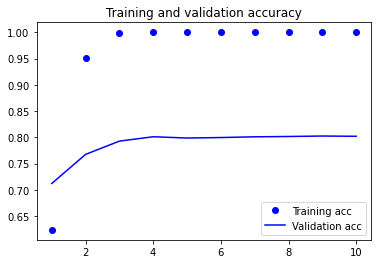

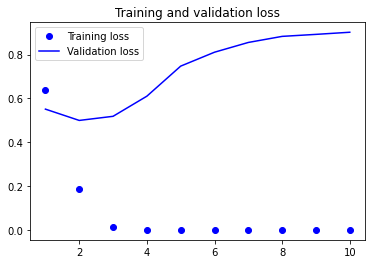

In [14]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)
               
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
               
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()